In [54]:
import pandas as pd

data = pd.read_excel("Данные 1.xlsx")
data['DATE'] = pd.to_datetime(data['DATE'], format='%Y-%m-%d')
data.sort_values(by="DATE",inplace=True)
data.drop(["Unnamed: 0","DATE"],axis=1,inplace=True)
data.reset_index(drop=True,inplace=True)
data.head()

,ALRS,ROLO,ISKJ,GAZP,LSRG,PIKK,SBER,MOEX,MGNT,GCHE
0,0.013102,-0.012078,0.001335,-0.003099,0.078053,-0.005079,-0.006239,0.045146,-0.071908,0.037924
1,-0.062792,-0.021601,0.054785,-0.015193,-0.012238,-0.010521,0.010576,0.049931,-0.069557,0.022032
2,-0.010933,-0.023452,0.009813,-0.031911,0.023256,0.006003,0.022033,-0.027305,0.027750,-0.046118
3,-0.078282,-0.006166,-0.033670,0.023590,0.001613,-0.003150,0.006485,-0.030803,0.003764,0.048348
4,0.040595,-0.020534,0.062573,0.062786,0.000000,-0.012442,-0.065311,-0.056681,0.094780,-0.033898


In [55]:
train_data = data[:len(data)//2]
test_data = data[len(data)//2:]

In [56]:
import numpy as np

cov_matrix = train_data.cov()
test_cov = test_data.cov()
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
# Сортировка собственных значений и векторов по убыванию
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

In [57]:
def online_gradient_descent(R_generator, b, I_feat, u_list, max_iters=100):
    """
    Выполняет онлайн-градиентный спуск с проекцией для минимизации:
        min sum_{j=1}^{N} ( <g_j, μ> )^2,  при условии <I_hat, μ> = 1
    
    Аргументы:
      R_generator  - функция, возвращающая случайное наблюдение R (вектор размерности d)
      b            - вектор b (размерность d)
      I_feat       - базовый вектор признаков (например, вектор единиц, размерность d)
      u_list       - список из m векторов (например, первые m собственных векторов)
      max_iters    - число итераций (по умолчанию 30)
    
    Возвращает:
      μ       - финальный вектор параметров (размер m+1)
      errors  - список значений ошибки на каждой итерации
    """
    m = len(u_list)
    # Формируем вектор для проекции: I_hat = [<I_feat, I_feat>, <u_list[0], I_feat>, ..., <u_list[m-1], I_feat>]
    I_hat = np.zeros(m + 2)
    I_hat[0] = np.dot(b, I_feat)
    I_hat[1] = np.dot(I_feat, I_feat)
    for i in range(m):
        I_hat[i+2] = np.dot(u_list[i], I_feat)
    
    # Нормировочная константа, чтобы обеспечить условие <I_hat, μ> = 1
    S = I_hat.sum()
    mu = np.ones(m + 2) / S
    errors = []
    error = 0
    
    for j in range(max_iters):
        R = R_generator()       # получаем наблюдение R (размер d)
        diff = R - b            # разница R - b
        
        b_hat = np.zeros(m + 2)
        b_hat[0] = np.dot(b, b)
        b_hat[1] = np.dot(I_feat, b)
        for i in range(m):
            b_hat[i+2] = np.dot(u_list[i], I_feat)

        # Формируем вектор градиента g:
        # g[0] = <I_feat, R-b>, g[i+1] = <u_list[i], R-b>
        g = np.zeros(m + 2)
        g[0] = np.dot(b, diff)
        g[1] = np.dot(I_feat, diff)
        for i in range(m):
            g[i+2] = np.dot(u_list[i], diff)
        
        # Выбираем шаг h 
        h = 1 / (j + 1)
        grad_scale = np.dot(g, mu)
        # Градиентный шаг:
        v = mu - h * grad_scale * g
        
        a1 = np.dot(I_hat,I_hat)
        b1 = np.dot(b_hat,I_hat)
        c1 = 1 - np.dot(v,I_hat)
        
        a2 = np.dot(b_hat,I_hat)
        b2 = np.dot(b_hat,b_hat)
        c2 = 0 - np.dot(v,b_hat)
        
        solution = np.linalg.solve([[a1,b1],[a2,b2]], [c1,c2])
        
        mu = v + solution[0]*I_hat + solution[1]*b_hat
        
        
        # Ошибка на текущей итерации:
        err = np.dot(g, mu) ** 2
        error += err
        errors.append(error/(j+1))
        print(f"Epoch: {j + 1}, error: {err}")
    
    return mu, errors

In [70]:
import random

m = 4  # число выбранных собственных векторов
# Размерность (количество признаков) определяется по количеству строк в eigenvectors
d = eigenvectors.shape[0]
# Вектор I_feat – базовый вектор признаков (например, вектор единиц)
I_feat = np.ones(d)
# Список u_list – первые m собственных векторов
u_list = [eigenvectors[:, i] for i in range(m)]
# Вектор b (например, вектор единиц той же размерности)
b = np.mean(data.values,axis=0)
    
# Генератор наблюдений R: функция, возвращающая случайный вектор размерности d
def R_gen():
    return random.choice(data.values)

In [71]:
mu, errors = online_gradient_descent(R_gen,b, I_feat, u_list, max_iters=20)

Epoch: 1, error: 0.0033902611584145804
Epoch: 2, error: 0.0004358009839032064
Epoch: 3, error: 0.00022072606825044894
Epoch: 4, error: 0.00012064989982123483
Epoch: 5, error: 6.57811799664796e-05
Epoch: 6, error: 3.919587129366068e-05
Epoch: 7, error: 0.0004771126115446701
Epoch: 8, error: 2.323658327943232e-05
Epoch: 9, error: 1.009632295719715e-06
Epoch: 10, error: 3.604051006402746e-05
Epoch: 11, error: 0.0034425608090450453
Epoch: 12, error: 0.0007699272003560958
Epoch: 13, error: 0.00031977265529076253
Epoch: 14, error: 0.0022289079608902337
Epoch: 15, error: 0.0008877603385078576
Epoch: 16, error: 0.0004273463844654407
Epoch: 17, error: 0.00020421135791426196
Epoch: 18, error: 0.0014125837957102625
Epoch: 19, error: 0.0006828296659587409
Epoch: 20, error: 0.00044113753020196624


In [72]:
x = mu[0] * b.copy() + mu[1] * I_feat.copy()
for i in range(m):
    x += mu[i + 2] * u_list[i]
    
print("\nФинальный вектор параметров φ:", mu)
print("Результирующий портфельный вектор x:", x)
print("Риск портфеля", np.dot(np.dot(cov_matrix,x),x))
print("Сумма x", x.sum())


Финальный вектор параметров φ: [0.10478826 0.10000509 0.12099651 0.08545108 0.07938474 0.09843523]
Результирующий портфельный вектор x: [0.05214764 0.22934537 0.00839389 0.07160746 0.13141522 0.08135944
 0.15531984 0.13579454 0.03736084 0.09725577]
Риск портфеля 0.0010205582573347084
Сумма x 0.9999999999999999


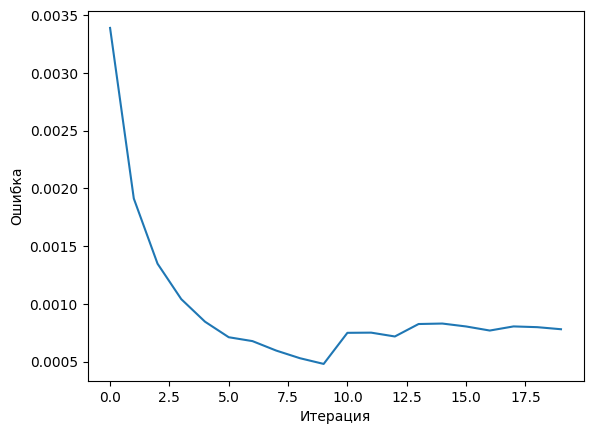

In [73]:
import matplotlib.pyplot as plt

plt.xlabel("Итерация")
plt.ylabel("Ошибка")
plt.plot(errors)
plt.savefig("mean-varinace_graph.png", dpi=300)

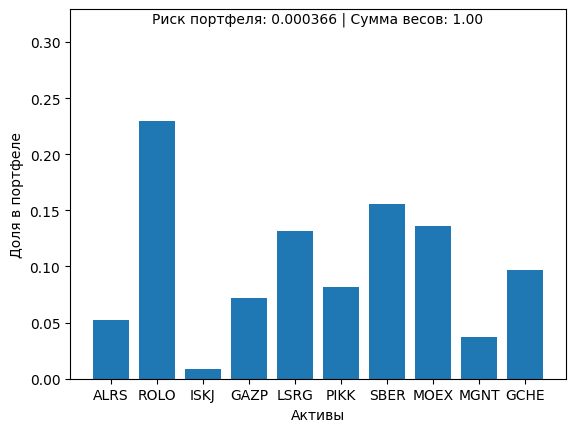

In [74]:
plt.bar(data.columns, x)
plt.ylabel('Доля в портфеле')
plt.xlabel('Активы')
plt.ylim(0, max(x) + 0.1)

# Общая аннотация
plt.title(f'Риск портфеля: {np.dot(np.dot(test_cov,x),x):.6f} | Сумма весов: {x.sum():.2f}', fontsize=10, y=0.94)

plt.savefig("portfolio_mean_variance.png", dpi=300)
plt.show()